In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pywt
import warnings

import torch
import torch.nn as nn

warnings.filterwarnings(action='ignore')

In [2]:
import yfinance as yf
# Define the ticker symbol
ticker_symbol = 'TSLA'  # Example: google Inc.
# Set the start and end dates for the data
# Fetch the data
data = yf.download(ticker_symbol)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


In [3]:
data.reset_index(inplace= True)

In [4]:
data[['Date','Close']]

,Date,Close
0,2010-06-29,1.592667
1,2010-06-30,1.588667
2,2010-07-01,1.464000
3,2010-07-02,1.280000
4,2010-07-06,1.074000
...,...,...
3489,2024-05-09,171.970001
3490,2024-05-10,168.470001
3491,2024-05-13,171.889999
3492,2024-05-14,177.550003


In [5]:
# slicing dataframe and reseting index 
df= data.iloc[1000:,:]
df.reset_index(drop= True,inplace=True)
df.head()
df.shape

(2494, 7)

In [6]:
df_1 = (df['Close'])
len(df_1)

2494

In [7]:
from sklearn.preprocessing import MinMaxScaler
Scaler = MinMaxScaler(feature_range=(0,1))
df_2 = Scaler.fit_transform(np.array(df_1).reshape(-1,1))

In [8]:
df_2

array([[0.01400627],
       [0.01430598],
       [0.0155764 ],
       ...,
       [0.40538272],
       [0.41951888],
       [0.4106276 ]])

In [9]:
from numpy import array

def split_sequence(sequence, n_steps):
    X,y = list(),list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i+n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            # gather input and ouput parts of the pattern
        seq_x,seq_y = sequence[i:end_ix],sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

In [10]:
window_size = 21
X,y = split_sequence(df_1,window_size)
print((X.ndim))
print(y.ndim)

2
1


In [11]:
# splittin dataset into train and test
train_size = int(len(df_2)*0.65)
test_size = len(df_2) - train_size
train_data = df_2[0:train_size,:]
print((train_data))
test_data = df_2[train_size:len(df_2),:1]

[[0.01400627]
 [0.01430598]
 [0.0155764 ]
 ...
 [0.39172945]
 [0.38368733]
 [0.41052767]]


In [12]:
X_train, y_train = split_sequence(train_data,window_size)
X_test, y_test = split_sequence(test_data,window_size)

In [13]:
X_train.shape,y_train.shape

((1600, 21, 1), (1600, 1))

In [14]:
X_test.shape,y_test.shape

((852, 21, 1), (852, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1600, 21, 1]),
 torch.Size([852, 21, 1]),
 torch.Size([1600, 1]),
 torch.Size([852, 1]))

In [16]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [17]:
train_dataset

In [18]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0], batch[1]
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 21, 1]) torch.Size([64, 1])


In [20]:
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, lstm_output):
        # lstm_output shape: (batch_size, sequence_length, hidden_size)
        attn_weights = self.attention(lstm_output)  # (batch_size, sequence_length, 1)
        attn_weights = F.softmax(attn_weights, dim=1)  # (batch_size, sequence_length, 1)
        context_vector = torch.sum(attn_weights * lstm_output, dim=1)  # (batch_size, hidden_size)
        return context_vector, attn_weights

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 60, 1)
print(model)

LSTM(
  (lstm): LSTM(1, 60, batch_first=True)
  (attention): Attention(
    (attention): Linear(in_features=60, out_features=1, bias=False)
  )
  (fc): Linear(in_features=60, out_features=1, bias=True)
)


In [22]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0], batch[1]
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [23]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0], batch[1]
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [24]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.269
***************************************************

Epoch: 2

Val Loss: 0.272
***************************************************

Epoch: 3

Val Loss: 0.256
***************************************************

Epoch: 4

Val Loss: 0.237
***************************************************

Epoch: 5

Val Loss: 0.214
***************************************************

Epoch: 6

Val Loss: 0.179
***************************************************

Epoch: 7

Val Loss: 0.125
***************************************************

Epoch: 8

Val Loss: 0.052
***************************************************

Epoch: 9

Val Loss: 0.008
***************************************************

Epoch: 10

Val Loss: 0.157
***************************************************

Epoch: 11

Val Loss: 0.124
***************************************************

Epoch: 12

Val Loss: 0.112
***************************************************

Epoch: 13

Val Loss: 0.081
**********************

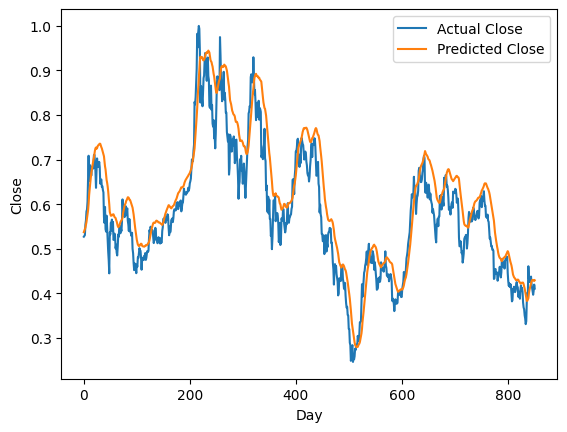

In [26]:
with torch.no_grad():
    predicted = model(X_test).numpy()

plt.plot(y_test, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


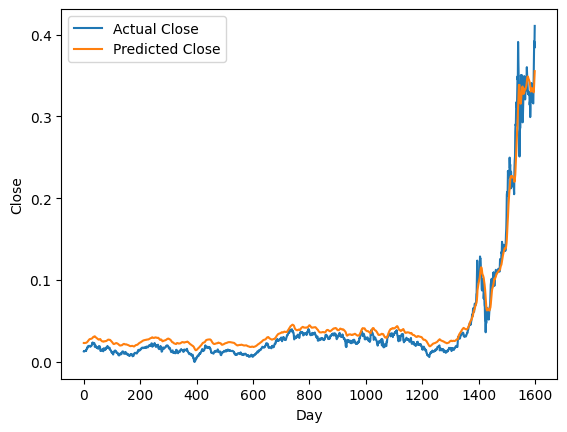

In [27]:
with torch.no_grad():
    predicted = model(X_train).numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [ ]:
pd.DataFrame()

In [59]:
X_train.shape

torch.Size([1598, 21, 1])

In [60]:
y_train.shape

torch.Size([1598, 1])